In [1]:
!pip install -q flwr[simulation] torch torchvision

In [3]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, NamedTuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
import time
import flwr as fl
from scipy import stats as st
import json

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cuda using PyTorch 2.3.1 and Flower 1.9.0


In [4]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
   process = psutil.Process(os.getpid())
   print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
   print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 113.0 GB  | Proc size: 510.8 MB
GPU RAM Free: 14877MB | Used: 1291MB | Util   8% | Total 16376MB


In [5]:
NUM_CLIENTS = 10


def load_datasets(num_clients: int):
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    # Split training set into `num_clients` partitions to simulate different local datasets
    partition_size = len(trainset) // num_clients
    lengths = [partition_size] * num_clients
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=32, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=32))
    testloader = DataLoader(testset, batch_size=32)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

class ClientMetrics(NamedTuple):
    epoch: int
    loss: float
    accuracy: float

def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    metrics = []
    for epoch in range(epochs):  # Use the passed 'epochs' variable here
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss.item()  # Make sure to call .item() to get the scalar value
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        metrics.append(ClientMetrics(epoch, epoch_loss, epoch_acc))
        print(f"Epoch {epoch}: train loss {epoch_loss:.6f}, accuracy {epoch_acc:.6f}")
    return metrics


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [7]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        epochs = config.get("epochs", 1)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs)
        training_time = time.time() - start_time  # Calculate duration
        print(f"Training time for Client {self.cid}: {training_time:.2f} seconds")
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}



    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [8]:
from typing import Callable, Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg


class FedCustom(fl.server.strategy.Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.client_training_times = {}
        self.client_metrics = {}
    def __repr__(self) -> str:
        return "FedCustom"

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return fl.common.ndarrays_to_parameters(ndarrays)

    def configure_fit(self, server_round: int, parameters: Parameters, client_manager: ClientManager):
        sample_size, min_num_clients = self.num_fit_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
        epochs_sc = 10
        

        standard_config = {"lr": 0.001, "epochs": epochs_sc}
        
        fit_configurations = []
        mode_time = []
        
        for client in clients:
            last_time = self.client_training_times.get(client.cid, [0,])[-1] # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is ths last time not a fantasy {last_time}and {client.cid}habhhahah")
            
            mode_time.append(round(last_time,2))
            print(f"this is tehb mode time {mode_time}")

        modest_value = st.mode(np.array(mode_time))
        print(f"Yeh h modest valueueueueu{modest_value}")
        print(f"yeh h server round {server_round}")
        min_value, max_value= np.min(modest_value),np.max(modest_value)
        print(f"this is the min value {min_value} and this is the max value {max_value}")
        
        if min_value == max_value:
            epochs_hl = epochs_sc   
        else:
            epochs_hl = int(np.floor((max_value-min_value)/max_value * epochs_sc)) 

        higher_lr_config = {"lr": 0.0001, "epochs": epochs_hl}
        print(f"The epochs for the higher lr is {epochs_hl} and the epochs for the standard lr is {epochs_sc}")




        for client in clients:
            # Choose config based on the previous training time
            last_time = self.client_training_times.get(client.cid, [0,])[-1]  # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is the last time {last_time}")
            


            config_to_use = standard_config if last_time < modest_value.mode else higher_lr_config
            fit_configurations.append((client, FitIns(parameters, config_to_use)))

        return fit_configurations
    
    def parse_metrics(self, cid, metrics: str): # this function has been added to parse the metrics from the client
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store = self.client_metrics.setdefault(cid, [])
        last_epoch = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2]))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            # Update training times for each client
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0)) # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            self.parse_metrics(client.cid, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated


    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate global model parameters using an evalua
        tion function."""

        # Let's assume we won't perform the global model evaluation on the server side.
        return None

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

In [9]:
if DEVICE.type == "cuda":
    # Use a single client to train the global model
    client_resources = {"num_gpus": .125, "num_cpus": 1} 

In [8]:
strategy = FedCustom()

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,  # <-- pass the new strategy here
    client_resources=client_resources,

)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-15 14:12:04,994	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'object_store_memory': 33993047654.0, 'node:127.0.0.1': 1.0, 'memory': 69317111194.0, 'GPU': 1.0, 'accelerator_type:RTX': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 0and 7habhhahah
this is tehb mode time [0]
This is ths last time not a fantasy 0and 4habhhahah
this is tehb mode time [0, 0]
This is ths last time not a fantasy 0and 2habhhahah
this is tehb mode time [0, 0, 0]
This is ths last time not a fantasy 0and 6habhhahah
this is tehb mode time [0, 0, 0, 0]
This is ths last time not a fantasy 0and 5habhhahah
this is tehb mode time [0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 8habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 1habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 3habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 9habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 0habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Yeh h modest valueueueueuModeResult(mode=0, count=10)
yeh h server round 1


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=4132) [Client 4] evaluate, config: {}
(ClientAppActor pid=4132) Training time for Client 0: 23.01 seconds
(ClientAppActor pid=4132) Epoch 9: train loss 0.037946, accuracy 0.564000
(ClientAppActor pid=15084) [Client 2] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 22.383253812789917and 4habhhahah
this is tehb mode time [22.38]
This is ths last time not a fantasy 23.08624029159546and 9habhhahah
this is tehb mode time [22.38, 23.09]
This is ths last time not a fantasy 22.128727912902832and 7habhhahah
this is tehb mode time [22.38, 23.09, 22.13]
This is ths last time not a fantasy 22.110109090805054and 5habhhahah
this is tehb mode time [22.38, 23.09, 22.13, 22.11]
This is ths last time not a fantasy 21.784307718276978and 6habhhahah
this is tehb mode time [22.38, 23.09, 22.13, 22.11, 21.78]
This is ths last time not a fantasy 22.10024905204773and 2habhhahah
this is tehb mode time [22.38, 23.09, 22.13, 22.11, 21.78, 22.1]
This is ths last time not a fantasy 22.229669332504272and 1habhhahah
this is tehb mode time [22.38, 23.09, 22.13, 22.11, 21.78, 22.1, 22.23]
This is ths last time not a fantasy 23.011198043823242and 0habhhahah
this is tehb mode time [22.38, 23.09, 22.13, 22.11, 21.78, 22.1, 22.23, 23.01]
This is t

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=11664) [Client 8] evaluate, config: {}
(ClientAppActor pid=11664) Epoch 8: train loss 0.028342, accuracy 0.676000 [repeated 2x across cluster]
(ClientAppActor pid=11664) Training time for Client 3: 21.10 seconds
(ClientAppActor pid=11664) [Client 4] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.148192405700684and 4habhhahah
this is tehb mode time [20.15]
This is ths last time not a fantasy 19.354995250701904and 2habhhahah
this is tehb mode time [20.15, 19.35]
This is ths last time not a fantasy 19.27944302558899and 1habhhahah
this is tehb mode time [20.15, 19.35, 19.28]
This is ths last time not a fantasy 19.495663166046143and 0habhhahah
this is tehb mode time [20.15, 19.35, 19.28, 19.5]
This is ths last time not a fantasy 19.455226182937622and 6habhhahah
this is tehb mode time [20.15, 19.35, 19.28, 19.5, 19.46]
This is ths last time not a fantasy 20.043762683868408and 7habhhahah
this is tehb mode time [20.15, 19.35, 19.28, 19.5, 19.46, 20.04]
This is ths last time not a fantasy 21.096603393554688and 3habhhahah
this is tehb mode time [20.15, 19.35, 19.28, 19.5, 19.46, 20.04, 21.1]
This is ths last time not a fantasy 20.51872229576111and 8habhhahah
this is tehb mode time [20.15, 19.35, 19.28, 19.5, 19.46, 20.04, 21.1, 20.52]
This is ths l

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=11664) [Client 6] evaluate, config: {}
(ClientAppActor pid=11664) Epoch 8: train loss 0.016046, accuracy 0.823333 [repeated 2x across cluster]
(ClientAppActor pid=11664) Training time for Client 9: 20.24 seconds
(ClientAppActor pid=39336) [Client 8] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.23738193511963and 9habhhahah
this is tehb mode time [20.24]
This is ths last time not a fantasy 20.741327047348022and 5habhhahah
this is tehb mode time [20.24, 20.74]
This is ths last time not a fantasy 19.102004289627075and 8habhhahah
this is tehb mode time [20.24, 20.74, 19.1]
This is ths last time not a fantasy 19.73255681991577and 0habhhahah
this is tehb mode time [20.24, 20.74, 19.1, 19.73]
This is ths last time not a fantasy 19.981184005737305and 4habhhahah
this is tehb mode time [20.24, 20.74, 19.1, 19.73, 19.98]
This is ths last time not a fantasy 19.556848287582397and 3habhhahah
this is tehb mode time [20.24, 20.74, 19.1, 19.73, 19.98, 19.56]
This is ths last time not a fantasy 19.301225185394287and 7habhhahah
this is tehb mode time [20.24, 20.74, 19.1, 19.73, 19.98, 19.56, 19.3]
This is ths last time not a fantasy 19.54186463356018and 2habhhahah
this is tehb mode time [20.24, 20.74, 19.1, 19.73, 19.98, 19.56, 19.3, 19.54]
This is ths las

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=34884) Epoch 8: train loss 0.007461, accuracy 0.924889 [repeated 3x across cluster]
(ClientAppActor pid=34884) [Client 3] evaluate, config: {}
(ClientAppActor pid=34884) Training time for Client 1: 21.02 seconds
(ClientAppActor pid=25132) [Client 2] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 19.42887806892395and 8habhhahah
this is tehb mode time [19.43]
This is ths last time not a fantasy 21.024577379226685and 1habhhahah
this is tehb mode time [19.43, 21.02]
This is ths last time not a fantasy 20.433032751083374and 6habhhahah
this is tehb mode time [19.43, 21.02, 20.43]
This is ths last time not a fantasy 19.191006660461426and 5habhhahah
this is tehb mode time [19.43, 21.02, 20.43, 19.19]
This is ths last time not a fantasy 19.669053316116333and 7habhhahah
this is tehb mode time [19.43, 21.02, 20.43, 19.19, 19.67]
This is ths last time not a fantasy 19.009630918502808and 3habhhahah
this is tehb mode time [19.43, 21.02, 20.43, 19.19, 19.67, 19.01]
This is ths last time not a fantasy 19.09342622756958and 4habhhahah
this is tehb mode time [19.43, 21.02, 20.43, 19.19, 19.67, 19.01, 19.09]
This is ths last time not a fantasy 19.628685235977173and 0habhhahah
this is tehb mode time [19.43, 21.02, 20.43, 19.19, 19.67, 19.01, 19.09, 19.63]
This i

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=34884) [Client 4] evaluate, config: {}
(ClientAppActor pid=34884) Epoch 8: train loss 0.004219, accuracy 0.962889 [repeated 2x across cluster]
(ClientAppActor pid=34884) Training time for Client 2: 20.63 seconds
(ClientAppActor pid=39816) [Client 0] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 19.664191722869873and 1habhhahah
this is tehb mode time [19.66]
This is ths last time not a fantasy 19.787410736083984and 4habhhahah
this is tehb mode time [19.66, 19.79]
This is ths last time not a fantasy 19.479397535324097and 0habhhahah
this is tehb mode time [19.66, 19.79, 19.48]
This is ths last time not a fantasy 19.399154901504517and 6habhhahah
this is tehb mode time [19.66, 19.79, 19.48, 19.4]
This is ths last time not a fantasy 20.157179594039917and 9habhhahah
this is tehb mode time [19.66, 19.79, 19.48, 19.4, 20.16]
This is ths last time not a fantasy 21.249696254730225and 3habhhahah
this is tehb mode time [19.66, 19.79, 19.48, 19.4, 20.16, 21.25]
This is ths last time not a fantasy 20.258308172225952and 8habhhahah
this is tehb mode time [19.66, 19.79, 19.48, 19.4, 20.16, 21.25, 20.26]
This is ths last time not a fantasy 20.62925386428833and 2habhhahah
this is tehb mode time [19.66, 19.79, 19.48, 19.4, 20.16, 21.25, 20.26, 20.63]
This is th

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=25132) [Client 0] evaluate, config: {}
(ClientAppActor pid=25132) Epoch 8: train loss 0.002155, accuracy 0.985778 [repeated 2x across cluster]
(ClientAppActor pid=25132) Training time for Client 5: 20.11 seconds
(ClientAppActor pid=4132) [Client 7] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 19.943084955215454and 4habhhahah
this is tehb mode time [19.94]
This is ths last time not a fantasy 20.076821088790894and 1habhhahah
this is tehb mode time [19.94, 20.08]
This is ths last time not a fantasy 20.114481210708618and 5habhhahah
this is tehb mode time [19.94, 20.08, 20.11]
This is ths last time not a fantasy 19.026185750961304and 6habhhahah
this is tehb mode time [19.94, 20.08, 20.11, 19.03]
This is ths last time not a fantasy 19.061928033828735and 2habhhahah
this is tehb mode time [19.94, 20.08, 20.11, 19.03, 19.06]
This is ths last time not a fantasy 19.08910608291626and 9habhhahah
this is tehb mode time [19.94, 20.08, 20.11, 19.03, 19.06, 19.09]
This is ths last time not a fantasy 19.753637552261353and 0habhhahah
this is tehb mode time [19.94, 20.08, 20.11, 19.03, 19.06, 19.09, 19.75]
This is ths last time not a fantasy 19.402647256851196and 3habhhahah
this is tehb mode time [19.94, 20.08, 20.11, 19.03, 19.06, 19.09, 19.75, 19.4]
This i

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=34884) [Client 3] evaluate, config: {}
(ClientAppActor pid=34884) Training time for Client 8: 19.88 seconds
(ClientAppActor pid=34884) Epoch 8: train loss 0.003632, accuracy 0.963333
(ClientAppActor pid=25132) [Client 9] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 19.111013174057007and 0habhhahah
this is tehb mode time [19.11]
This is ths last time not a fantasy 19.477521657943726and 4habhhahah
this is tehb mode time [19.11, 19.48]
This is ths last time not a fantasy 19.562015771865845and 2habhhahah
this is tehb mode time [19.11, 19.48, 19.56]
This is ths last time not a fantasy 20.080206155776978and 7habhhahah
this is tehb mode time [19.11, 19.48, 19.56, 20.08]
This is ths last time not a fantasy 21.404783248901367and 6habhhahah
this is tehb mode time [19.11, 19.48, 19.56, 20.08, 21.4]
This is ths last time not a fantasy 19.25559139251709and 3habhhahah
this is tehb mode time [19.11, 19.48, 19.56, 20.08, 21.4, 19.26]
This is ths last time not a fantasy 19.87854766845703and 8habhhahah
this is tehb mode time [19.11, 19.48, 19.56, 20.08, 21.4, 19.26, 19.88]
This is ths last time not a fantasy 19.751043558120728and 9habhhahah
this is tehb mode time [19.11, 19.48, 19.56, 20.08, 21.4, 19.26, 19.88, 19.75]
This is th

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=34884) [Client 9] evaluate, config: {}
(ClientAppActor pid=34884) Training time for Client 5: 23.13 seconds
(ClientAppActor pid=34884) Epoch 9: train loss 0.000406, accuracy 0.999333
(ClientAppActor pid=39336) [Client 1] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 17.426373720169067and 7habhhahah
this is tehb mode time [17.43]
This is ths last time not a fantasy 16.90569233894348and 2habhhahah
this is tehb mode time [17.43, 16.91]
This is ths last time not a fantasy 16.81387448310852and 9habhhahah
this is tehb mode time [17.43, 16.91, 16.81]
This is ths last time not a fantasy 17.28839945793152and 4habhhahah
this is tehb mode time [17.43, 16.91, 16.81, 17.29]
This is ths last time not a fantasy 23.140763521194458and 1habhhahah
this is tehb mode time [17.43, 16.91, 16.81, 17.29, 23.14]
This is ths last time not a fantasy 23.128037452697754and 5habhhahah
this is tehb mode time [17.43, 16.91, 16.81, 17.29, 23.14, 23.13]
This is ths last time not a fantasy 22.16998600959778and 0habhhahah
this is tehb mode time [17.43, 16.91, 16.81, 17.29, 23.14, 23.13, 22.17]
This is ths last time not a fantasy 17.319199562072754and 6habhhahah
this is tehb mode time [17.43, 16.91, 16.81, 17.29, 23.14, 23.13, 22.17, 17.32]
This is 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=11664) Epoch 8: train loss 0.003559, accuracy 0.964667 [repeated 5x across cluster]
(ClientAppActor pid=11664) [Client 0] evaluate, config: {}
(ClientAppActor pid=11664) Training time for Client 3: 20.96 seconds
(ClientAppActor pid=4264) [Client 2] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures


(ClientAppActor pid=25132) [Client 9] evaluate, config: {} [repeated 5x across cluster]


INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.962723970413208and 3habhhahah
this is tehb mode time [20.96]
This is ths last time not a fantasy 19.754369020462036and 9habhhahah
this is tehb mode time [20.96, 19.75]
This is ths last time not a fantasy 19.09251880645752and 0habhhahah
this is tehb mode time [20.96, 19.75, 19.09]
This is ths last time not a fantasy 19.68445658683777and 4habhhahah
this is tehb mode time [20.96, 19.75, 19.09, 19.68]
This is ths last time not a fantasy 19.316243886947632and 1habhhahah
this is tehb mode time [20.96, 19.75, 19.09, 19.68, 19.32]
This is ths last time not a fantasy 19.809374809265137and 5habhhahah
this is tehb mode time [20.96, 19.75, 19.09, 19.68, 19.32, 19.81]
This is ths last time not a fantasy 19.335922718048096and 6habhhahah
this is tehb mode time [20.96, 19.75, 19.09, 19.68, 19.32, 19.81, 19.34]
This is ths last time not a fantasy 19.867839097976685and 2habhhahah
this is tehb mode time [20.96, 19.75, 19.09, 19.68, 19.32, 19.81, 19.34, 19.87]
This i

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=11664) [Client 6] evaluate, config: {}
(ClientAppActor pid=11664) Training time for Client 7: 20.13 seconds
(ClientAppActor pid=11664) Epoch 8: train loss 0.003043, accuracy 0.968667
(ClientAppActor pid=39816) [Client 9] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 582.76s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06287062201499939
INFO :      		round 2: 0.04257627120018005
INFO :      		round 3: 0.045332734060287476
INFO :      		round 4: 0.05283787411451339
INFO :      		round 5: 0.05986989566087723
INFO :      		round 6: 0.06574931528568267
INFO :      		round 7: 0.06771944273710251
INFO :      		round 8: 0.07133315708637238
INFO :      		round 9: 0.07669851977825165
INFO :      		round 10: 0.07720335643887519
INFO :      


History (loss, distributed):
	round 1: 0.06287062201499939
	round 2: 0.04257627120018005
	round 3: 0.045332734060287476
	round 4: 0.05283787411451339
	round 5: 0.05986989566087723
	round 6: 0.06574931528568267
	round 7: 0.06771944273710251
	round 8: 0.07133315708637238
	round 9: 0.07669851977825165
	round 10: 0.07720335643887519

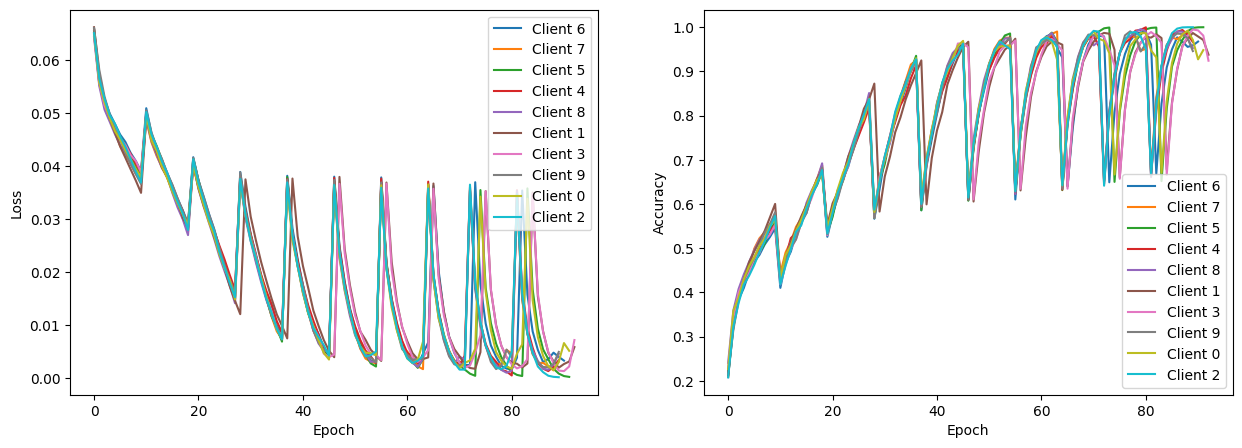

In [9]:
import matplotlib.pyplot as plt


def plot_metrics(client_metrics):
    # client_metrics = strategy.client_metrics
    client_ids = list(client_metrics.keys())

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        losses = [metric.loss for metric in client_metrics[cid]]
        axs[0].plot(epochs, losses, label=f"Client {cid}")

    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        accuracies = [metric.accuracy for metric in client_metrics[cid]]
        axs[1].plot(epochs, accuracies, label=f"Client {cid}")

    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

    plt.show()

plot_metrics(strategy.client_metrics)

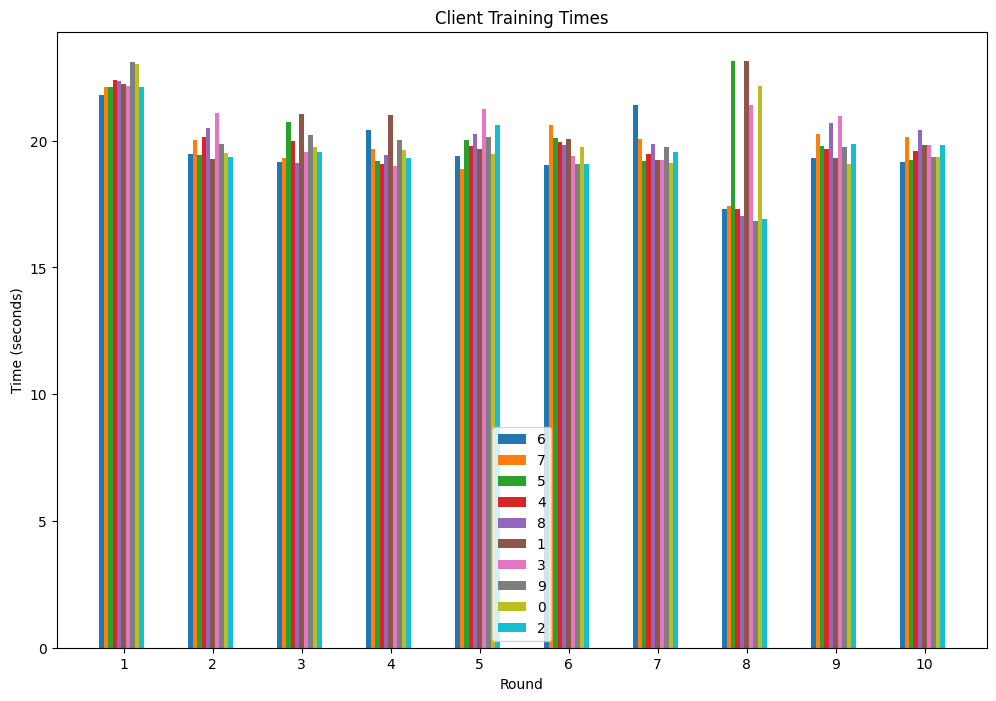

In [10]:
def plot_times(client_training_times):
    client_ids = list(client_training_times.keys())
    num_rounds = len(client_training_times[client_ids[0]])

    x = np.arange(num_rounds)  # Positions of the bars
    bar_width = 0.05 # Width of bars
    fig, ax = plt.subplots(figsize=(12, 8))

    for i, client_id in enumerate(client_ids):
        times = client_training_times[client_id]
        ax.bar(x + i * bar_width, times, bar_width, label=client_id)

    ax.set_xlabel("Round")
    ax.set_ylabel("Time (seconds)")
    ax.set_title("Client Training Times")
    ax.set_xticks(x + bar_width * round(len(client_ids) / 2))
    ax.set_xticklabels(np.arange(1, num_rounds + 1))
    ax.legend()

    plt.show()

plot_times(strategy.client_training_times)

In [11]:
for a in strategy.client_metrics:
    print(f"Client {a} metrics: {len(strategy.client_metrics[a])}")

Client 6 metrics: 91
Client 7 metrics: 90
Client 5 metrics: 92
Client 4 metrics: 90
Client 8 metrics: 90
Client 1 metrics: 93
Client 3 metrics: 93
Client 9 metrics: 90
Client 0 metrics: 92
Client 2 metrics: 90


In [10]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs=10)
        training_time = time.time() - start_time  # Calculate duration
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        print(f"Client {self.cid} loss {loss}")
        print(f"Client {self.cid} accuracy {accuracy}")
        
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE) #Load Model from here
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [11]:
class FedAvgCustom(fl.server.strategy.FedAvg):
    def __init__(
        self,
        fraction_fit = 1.0,
        fraction_evaluate = 1.0,
        min_fit_clients = 2,
        min_evaluate_clients = 2,
        min_available_clients = 2,
    ):
        super().__init__(fraction_fit = fraction_fit, fraction_evaluate = fraction_evaluate, min_fit_clients = min_fit_clients, min_evaluate_clients = min_evaluate_clients, min_available_clients = min_available_clients)
        self.client_training_times = {}
        self.client_metrics = {}

    def parse_metrics(self, cid, metrics: str):
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store = self.client_metrics.setdefault(cid, [])
        last_epoch = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2]))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0))
            self.parse_metrics(client.cid, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated

# fl.simulation.start_simulation(
#     client_fn=client_fn,
#     num_clients=10,
#     config=fl.server.ServerConfig(num_rounds=10),
#     client_resources=client_resources,
# )

In [20]:
strategy_fed_avg = FedAvgCustom()

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=10),
    client_resources=client_resources,
    strategy=strategy_fed_avg,
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-15 14:35:52,884	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'object_store_memory': 33861717196.0, 'node:127.0.0.1': 1.0, 'memory': 69010673460.0, 'GPU': 1.0, 'accelerator_type:RTX': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=18396) [Client 2] get_parameters
(ClientAppActor pid=18396) [Client 1] fit, config: {}
(ClientAppActor pid=18396) Epoch 0: train loss 0.064305, accuracy 0.244667
(ClientAppActor pid=18396) Epoch 1: train loss 0.054882, accuracy 0.355778
(ClientAppActor pid=21244) [Client 8] fit, config: {}
(ClientAppActor pid=18396) Epoch 2: train loss 0.050953, accuracy 0.396667
(ClientAppActor pid=21244) Epoch 0: train loss 0.065023, accuracy 0.229778
(ClientAppActor pid=18396) Epoch 3: train loss 0.047942, accuracy 0.438444
(ClientAppActor pid=32280) [Client 4] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=34312) Epoch 1: train loss 0.056069, accuracy 0.334889 [repeated 12x across cluster]
(ClientAppActor pid=33616) [Client 2] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=32888) Epoch 4: train loss 0.046401, accuracy 0.456222 [repeated 19x across cluster]
(ClientAppActor pid=18396) [Client 7] fit, config: {}
(ClientAppActor pid=42232) Epoch 7

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=21244) Epoch 9: train loss 0.038014, accuracy 0.563111 [repeated 2x across cluster]
(ClientAppActor pid=21244) [Client 9] evaluate, config: {}
(ClientAppActor pid=21244) Client 9 loss 0.052737845420837405
(ClientAppActor pid=21244) Client 9 accuracy 0.432
(ClientAppActor pid=34312) [Client 6] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=32280) Client 0 loss 0.05322059726715088 [repeated 4x across cluster]
(ClientAppActor pid=32280) Client 0 accuracy 0.424 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=18396) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=18396) Client 8 loss 0.05206651520729065 [repeated 5x across cluster]
(ClientAppActor pid=18396) Client 8 accuracy 0.436 [repeated 5x across cluster]
(ClientAppActor pid=18396) [Client 2] fit, config: {}
(ClientAppActor pid=18396) Epoch 0: train loss 0.047210, accuracy 0.454222
(ClientAppActor pid=32280) [Client 1] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=32280) Epoch 0: train loss 0.045932, accuracy 0.464000 [repeated 8x across cluster]
(ClientAppActor pid=33616) [Client 7] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=42232) Epoch 2: train loss 0.039854, accuracy 0.536444 [repeated 23x across cluster]
(ClientAppActor pid=32888) Epoch 6: train loss 0.031955, accuracy 0.635333 [repeated 18x across cluster]
(ClientAppActor pid=18396) [Client 4] fit, config: {}
(ClientAppActor pid=42232) Epoch 6: train loss 0.030594, accuracy 0.652889 [rep

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=34312) Epoch 9: train loss 0.023847, accuracy 0.722222 [repeated 5x across cluster]
(ClientAppActor pid=34312) [Client 2] evaluate, config: {}
(ClientAppActor pid=34312) Client 2 loss 0.044340750336647035
(ClientAppActor pid=34312) Client 2 accuracy 0.542
(ClientAppActor pid=37544) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=34312) Client 1 loss 0.04225182998180389 [repeated 4x across cluster]
(ClientAppActor pid=34312) Client 1 accuracy 0.546 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=33616) [Client 3] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=33616) Client 3 loss 0.04201943862438202 [repeated 5x across cluster]
(ClientAppActor pid=33616) Client 3 accuracy 0.536 [repeated 5x across cluster]
(ClientAppActor pid=33616) [Client 2] fit, config: {}
(ClientAppActor pid=33616) Epoch 0: train loss 0.040256, accuracy 0.537333
(ClientAppActor pid=37544) [Client 1] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=18396) Epoch 2: train loss 0.031681, accuracy 0.638667 [repeated 9x across cluster]
(ClientAppActor pid=21244) [Client 5] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=42232) Epoch 3: train loss 0.027874, accuracy 0.683111 [repeated 21x across cluster]
(ClientAppActor pid=18396) Epoch 7: train loss 0.016218, accuracy 0.824889 [repeated 19x across cluster]
(ClientAppActor pid=37544) Epoch 7: train loss 0.015839, accuracy 0.824222 [repeated 16x across cluster]
(ClientAppActor pid=33616) [

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=18396) Epoch 9: train loss 0.010711, accuracy 0.887556 [repeated 5x across cluster]
(ClientAppActor pid=18396) [Client 5] evaluate, config: {}
(ClientAppActor pid=18396) Client 5 loss 0.04561331796646118
(ClientAppActor pid=18396) Client 5 accuracy 0.588
(ClientAppActor pid=18396) [Client 7] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=37544) Client 6 loss 0.046815426349639894 [repeated 4x across cluster]
(ClientAppActor pid=37544) Client 6 accuracy 0.562 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=33616) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=33616) Client 0 loss 0.045667538523674014 [repeated 5x across cluster]
(ClientAppActor pid=33616) Client 0 accuracy 0.542 [repeated 5x across cluster]
(ClientAppActor pid=33616) [Client 8] fit, config: {}
(ClientAppActor pid=33616) Epoch 0: train loss 0.037289, accuracy 0.580889
(ClientAppActor pid=18396) [Client 3] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=33616) Epoch 2: train loss 0.024748, accuracy 0.725556 [repeated 8x across cluster]
(ClientAppActor pid=21244) [Client 9] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=32280) Epoch 3: train loss 0.020594, accuracy 0.767556 [repeated 21x across cluster]
(ClientAppActor pid=37544) Epoch 6: train loss 0.011543, accuracy 0.878667 [repeated 20x across cluster]
(ClientAppActor pid=33616) [Client 7] fit, config: {}
(ClientAppActor pid=21244) Epoch 6: train loss 0.012376, accuracy 0.868444 [re

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=42232) Epoch 9: train loss 0.005176, accuracy 0.951111 [repeated 5x across cluster]
(ClientAppActor pid=42232) [Client 3] evaluate, config: {}
(ClientAppActor pid=42232) Client 3 loss 0.06121403217315674
(ClientAppActor pid=42232) Client 3 accuracy 0.55
(ClientAppActor pid=42232) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=18396) Client 6 loss 0.05484129190444946 [repeated 4x across cluster]
(ClientAppActor pid=18396) Client 6 accuracy 0.572 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=33616) [Client 5] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=33616) Client 5 loss 0.053916300773620605 [repeated 5x across cluster]
(ClientAppActor pid=33616) Client 5 accuracy 0.596 [repeated 5x across cluster]
(ClientAppActor pid=33616) [Client 0] fit, config: {}
(ClientAppActor pid=33616) Epoch 0: train loss 0.036853, accuracy 0.614222
(ClientAppActor pid=18396) [Client 2] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=33616) Epoch 2: train loss 0.020185, accuracy 0.777333 [repeated 8x across cluster]
(ClientAppActor pid=42232) [Client 7] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=37544) Epoch 4: train loss 0.011822, accuracy 0.875111 [repeated 21x across cluster]
(ClientAppActor pid=18396) Epoch 6: train loss 0.007234, accuracy 0.929111 [repeated 20x across cluster]
(ClientAppActor pid=32888) Epoch 7: train loss 0.005441, accuracy 0.945778 [repeated 17x across cluster]
(ClientAppActor pid=33616) 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=21244) Epoch 9: train loss 0.004656, accuracy 0.955333 [repeated 5x across cluster]
(ClientAppActor pid=21244) [Client 7] evaluate, config: {}
(ClientAppActor pid=21244) Client 7 loss 0.054927160382270815
(ClientAppActor pid=21244) Client 7 accuracy 0.598
(ClientAppActor pid=34312) [Client 9] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=32888) Client 8 loss 0.06381933891773224 [repeated 4x across cluster]
(ClientAppActor pid=32888) Client 8 accuracy 0.566 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=33616) [Client 6] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=33616) Client 6 loss 0.060391711235046386 [repeated 5x across cluster]
(ClientAppActor pid=33616) Client 6 accuracy 0.552 [repeated 5x across cluster]
(ClientAppActor pid=33616) [Client 5] fit, config: {}
(ClientAppActor pid=33616) Epoch 0: train loss 0.037994, accuracy 0.602000
(ClientAppActor pid=32280) [Client 0] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=33616) Epoch 2: train loss 0.017173, accuracy 0.806222 [repeated 8x across cluster]
(ClientAppActor pid=34312) [Client 7] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=33616) Epoch 5: train loss 0.006063, accuracy 0.943333 [repeated 22x across cluster]
(ClientAppActor pid=18396) Epoch 5: train loss 0.006137, accuracy 0.946000 [repeated 19x across cluster]
(ClientAppActor pid=33616) [Client 6] fit, config: {}
(ClientAppActor pid=32280) Epoch 8: train loss 0.004219, accuracy 0.959111 [re

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=21244) Epoch 9: train loss 0.003287, accuracy 0.967556 [repeated 5x across cluster]
(ClientAppActor pid=21244) [Client 4] evaluate, config: {}
(ClientAppActor pid=21244) Client 4 loss 0.06664188003540039
(ClientAppActor pid=21244) Client 4 accuracy 0.562
(ClientAppActor pid=18396) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=32888) Client 7 loss 0.059397647142410276 [repeated 3x across cluster]
(ClientAppActor pid=32888) Client 7 accuracy 0.594 [repeated 3x across cluster]
(ClientAppActor pid=33616) [Client 6] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=21244) Client 8 loss 0.06972073483467102 [repeated 5x across cluster]
(ClientAppActor pid=21244) Client 8 accuracy 0.566 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=33616) [Client 4] fit, config: {}
(ClientAppActor pid=33616) Client 6 loss 0.06649476790428162
(ClientAppActor pid=33616) Client 6 accuracy 0.552
(ClientAppActor pid=33616) Epoch 0: train loss 0.037936, accuracy 0.626222
(ClientAppActor pid=18396) [Client 5] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=42232) Epoch 2: train loss 0.013668, accuracy 0.846444 [repeated 11x across cluster]
(ClientAppActor pid=34312) [Client 3] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=21244) Epoch 4: train loss 0.007050, accuracy 0.930444 [repeated 21x across cluster]
(ClientAppActor pid=37544) Epoch 7: train loss 0.003199, accuracy 0.972667 [repeated 20x across cluster]
(ClientAppActor pid=33616) [Client 2] fit, config: {}
(ClientAppActor pid=21244) Epoch 9: train loss 0.004673, accuracy 0.954889 [repeated 19x across cluster]
(ClientAppActor pid=42232) [Client 7] fit, config: {}
(ClientAppActor pid=42232) Epoch 2: train loss 0.014909, accuracy

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=42232) Epoch 9: train loss 0.004574, accuracy 0.953556 [repeated 4x across cluster]
(ClientAppActor pid=42232) [Client 4] evaluate, config: {}
(ClientAppActor pid=42232) Client 4 loss 0.06946356105804444
(ClientAppActor pid=42232) Client 4 accuracy 0.548
(ClientAppActor pid=18396) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=32888) Client 3 loss 0.07500497770309449 [repeated 4x across cluster]
(ClientAppActor pid=32888) Client 3 accuracy 0.564 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=18396) [Client 6] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=18396) Client 6 loss 0.06778865981101989 [repeated 5x across cluster]
(ClientAppActor pid=18396) Client 6 accuracy 0.572 [repeated 5x across cluster]
(ClientAppActor pid=18396) [Client 9] fit, config: {}
(ClientAppActor pid=18396) Epoch 0: train loss 0.036990, accuracy 0.636667
(ClientAppActor pid=21244) [Client 6] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=18396) Epoch 3: train loss 0.007594, accuracy 0.925778 [repeated 12x across cluster]
(ClientAppActor pid=42232) [Client 1] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=32280) Epoch 4: train loss 0.005314, accuracy 0.951111 [repeated 20x across cluster]
(ClientAppActor pid=37544) Epoch 6: train loss 0.001704, accuracy 0.993333 [repeated 20x across cluster]
(ClientAppActor pid=18396) [Client 2] fit, config: {}
(ClientAppActor pid=32280) Epoch 9: train loss 0.007000, accuracy 0.922444 [re

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=32888) Epoch 9: train loss 0.005903, accuracy 0.934889 [repeated 4x across cluster]
(ClientAppActor pid=32888) [Client 5] evaluate, config: {}
(ClientAppActor pid=32888) Client 5 loss 0.06975988531112672
(ClientAppActor pid=32888) Client 5 accuracy 0.588
(ClientAppActor pid=21244) [Client 7] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=34312) Client 0 loss 0.06743013644218444 [repeated 4x across cluster]
(ClientAppActor pid=34312) Client 0 accuracy 0.566 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=18396) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=18396) Client 8 loss 0.06998661184310913 [repeated 5x across cluster]
(ClientAppActor pid=18396) Client 8 accuracy 0.568 [repeated 5x across cluster]
(ClientAppActor pid=18396) [Client 1] fit, config: {}
(ClientAppActor pid=18396) Epoch 0: train loss 0.036255, accuracy 0.650444
(ClientAppActor pid=21244) [Client 6] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=37544) Epoch 0: train loss 0.036961, accuracy 0.654667 [repeated 11x across cluster]
(ClientAppActor pid=34312) [Client 5] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=42232) Epoch 2: train loss 0.010683, accuracy 0.889333 [repeated 20x across cluster]
(ClientAppActor pid=37544) Epoch 5: train loss 0.002174, accuracy 0.984444 [repeated 19x across cluster]
(ClientAppActor pid=18396) [Client 7] fit, config: {}
(ClientAppActor pid=37544) Epoch 7: train loss 0.004834, accuracy 0.946000 [re

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=32888) Epoch 9: train loss 0.009200, accuracy 0.905333 [repeated 5x across cluster]
(ClientAppActor pid=32888) [Client 8] evaluate, config: {}
(ClientAppActor pid=32888) Client 8 loss 0.0734450387954712
(ClientAppActor pid=32888) Client 8 accuracy 0.566
(ClientAppActor pid=37544) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=42232) Client 2 loss 0.07219150280952454 [repeated 4x across cluster]
(ClientAppActor pid=42232) Client 2 accuracy 0.546 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=18396) [Client 1] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=18396) Client 1 loss 0.06886622190475464 [repeated 5x across cluster]
(ClientAppActor pid=18396) Client 1 accuracy 0.562 [repeated 5x across cluster]
(ClientAppActor pid=18396) [Client 9] fit, config: {}
(ClientAppActor pid=18396) Epoch 0: train loss 0.035331, accuracy 0.664667
(ClientAppActor pid=37544) [Client 2] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=42232) Epoch 0: train loss 0.036306, accuracy 0.650667 [repeated 11x across cluster]
(ClientAppActor pid=34312) [Client 0] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=32888) Epoch 2: train loss 0.008926, accuracy 0.908000 [repeated 20x across cluster]
(ClientAppActor pid=42232) Epoch 5: train loss 0.001685, accuracy 0.992000 [repeated 17x across cluster]
(ClientAppActor pid=18396) [Client 8] fit, config: {}
(ClientAppActor pid=21244) Epoch 9: train loss 0.009194, accuracy 0.896889 [re

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=21244) Epoch 9: train loss 0.010170, accuracy 0.893778 [repeated 5x across cluster]
(ClientAppActor pid=21244) [Client 8] evaluate, config: {}
(ClientAppActor pid=21244) Client 8 loss 0.07569374632835388
(ClientAppActor pid=21244) Client 8 accuracy 0.566
(ClientAppActor pid=37544) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=42232) Client 6 loss 0.06751618599891662 [repeated 4x across cluster]
(ClientAppActor pid=42232) Client 6 accuracy 0.57 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 616.28s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.052303227853775024
INFO :      		round 2: 0.04223435828685761
INFO :      		round 3: 0.04747697103023529
INFO :      		round 4: 0.05520351219177246
INFO :      		round 5: 0.06124276839494706
INFO :      		round 6: 0.06658507964611053
INFO :      		round 7: 0.06877406208515167
INFO :      		round 8: 0.0705177184700966
INFO :      		round 9: 0.07108843363523483
INFO :      		round 10: 0.07481125673055648
INFO :      


History (loss, distributed):
	round 1: 0.052303227853775024
	round 2: 0.04223435828685761
	round 3: 0.04747697103023529
	round 4: 0.05520351219177246
	round 5: 0.06124276839494706
	round 6: 0.06658507964611053
	round 7: 0.06877406208515167
	round 8: 0.0705177184700966
	round 9: 0.07108843363523483
	round 10: 0.07481125673055648

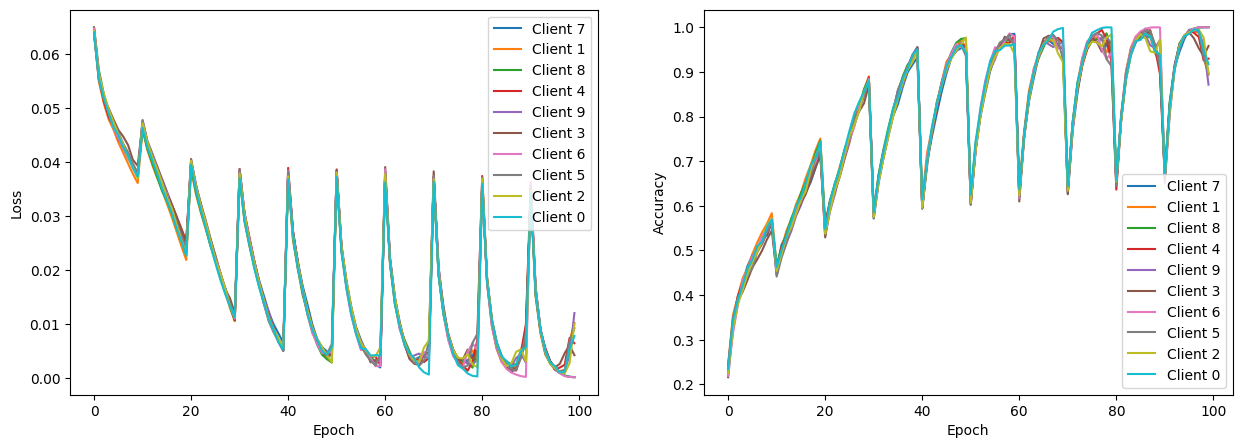

In [21]:
plot_metrics(strategy_fed_avg.client_metrics)

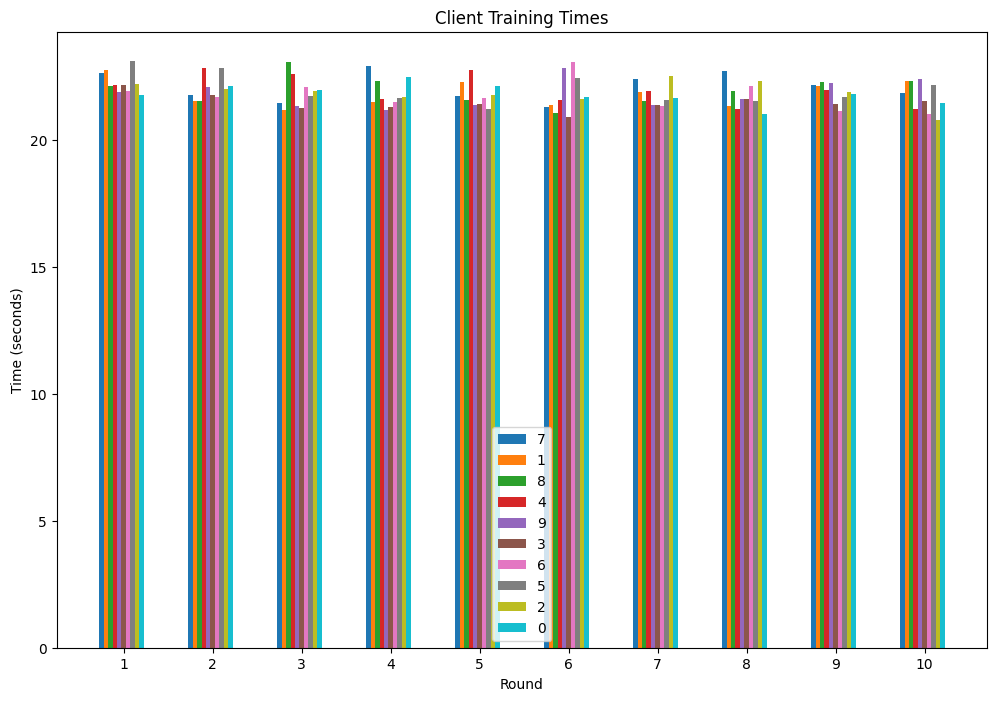

In [22]:
plot_times(strategy_fed_avg.client_training_times)